## Self-Organizing Map

In [2000]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs

import torch
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")

%matplotlib inline
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


### Implementation

In [1940]:
%%cython

import numpy as np
cimport numpy as npc

cpdef npc.ndarray euclidian(npc.ndarray a, npc.ndarray b, int axis=-1):
    return np.sqrt(np.sum(np.square(a - b), axis=axis))

cpdef calculate_theta(dst, dem):
     return np.mean(np.exp(-((np.square(dst))/dem)))

cpdef npc.ndarray find_neighbourhood(BMU, npc.ndarray lattice, radius=5):
    ngb = euclidian(BMU, lattice, axis=-1)
    return lattice[np.where((ngb > 0) & (ngb <= radius))]

In [1977]:
class SOM:
    
    def __init__(self, units=2, batch_size=32, lr=1e-1, radius=5):
        self._units = units
        self.W = None
        self._batch_size = batch_size
        self._lr = lr
        self._sig = 1
        self._radius = radius
    
    def train(self, x, epochs=1500, show_iter_err=10):
        qtd, self._size = x.shape
        # Define the Units Weights
        mn, mx, mm = np.min(x), np.max(x), np.mean(x)
        mn += mm
        mx -= mm
        nx, ny = np.meshgrid(np.linspace(mn, mx, self._units), np.linspace(mn, mx, self._units))
        idx = np.vstack((nx.ravel(), ny.ravel()))
        self.W = np.stack([ix - np.random.uniform(1e-2, 1e-1, 1) for ix in idx], axis=1)
        self.W = self.W.ravel().reshape(self._units, self._units, -1)
        # Create a lattice matrix to find the Neighbourhood of a BMU
        idx = np.indices(self.W.shape[:2])
        idx = np.vstack([ix.flatten() for ix in idx])
        self._lattice = np.stack([ix for ix in idx], axis=1)
        # Running epochs!
        for epoch in range(epochs):
            dem = (2*(np.square(self._sig)))
            for xi in x:
                # Find the BMU of the point
                dist = euclidian(xi, self.W, axis=-1)
                BMU = np.asarray(np.where(dist==np.min(dist))).ravel()[:self._size]
                # If found a BMU
                if BMU is not None:
                    # Find Neighbourhood of BMU using lattice matrix
                    ngb = find_neighbourhood(BMU, self._lattice, self._radius)
                    # Neighbourhood update
                    BMU_node = self.W[tuple(BMU)]
                    for ng in ngb:
                        indx = tuple(np.split(ng, self._size))
                        ngb_node = self.W[indx]
                        dst = euclidian(BMU_node, ngb_node, axis=-1)
                        theta = calculate_theta(dst, dem)
                        self.W[indx] += theta * (self._lr * (xi - ngb_node))
                    # BMU update
                    self.W[tuple(BMU)] += (self._lr * (xi - BMU_node))
            if epoch % 25 == 0 and epoch > 0:
                # Learning rate decay
                self._lr *= np.exp(-epoch/epochs)
                self._sig = self._radius * np.exp(-epoch/epochs)
                if self._radius > 1:
                    self._radius = int(self._radius * np.exp(-epoch/epochs))
    
    def predict(self, x):
        pass

### Toy datasets provided by scikit-learn

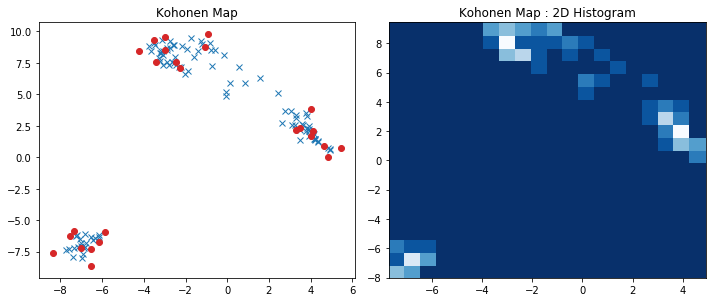

In [1978]:
x, y = make_blobs(25, n_features=2, centers=3, random_state=42)

som = SOM(units=10, lr=1e-1, radius=10)
som.train(x, epochs=100)
W = som.W
W = W.flatten().reshape(-1, 2)

fig = plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Kohonen Map")
plt.plot(W[:, 0], W[:, 1], 'x', c='C0')
plt.plot(x[:, 0], x[:, 1], 'o', c='C3')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map : 2D Histogram")
plt.hist2d(W[:, 0], W[:, 1], bins=20, cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

In [1991]:
X, y = make_moons(500, noise=0.075)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

som = SOM(units=20, lr=1e-1, radius=10)
som.train(X_train, epochs=100)
W = som.W.flatten().reshape(-1, 2)

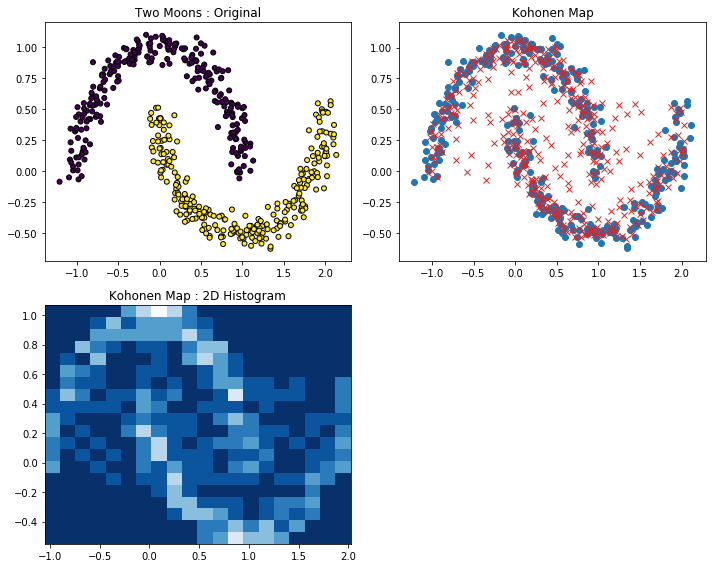

In [1992]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Two Moons : Original")
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hist2d(W[:, 0], W[:, 1], bins=20, cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

In [1993]:
X, y = make_classification(n_samples=500, n_features=2, n_classes=3, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

som = SOM(units=20, lr=1e-1, radius=10)
som.train(X_train, epochs=100)
W = som.W.flatten().reshape(-1, 2)

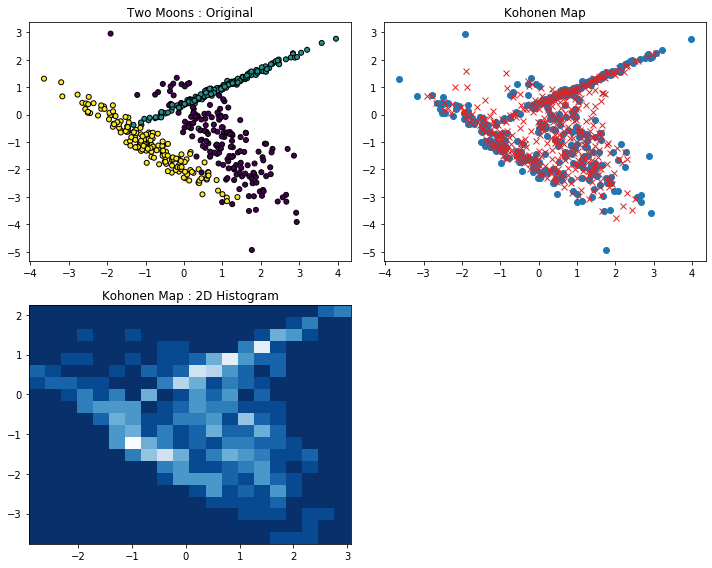

In [1994]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Two Moons : Original")
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hist2d(W[:, 0], W[:, 1], bins=20, cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

In [1995]:
X, y = make_circles(500, noise=0.03)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

som = SOM(units=20, lr=1e-1, radius=10)
som.train(X_train, epochs=100)
W = som.W.flatten().reshape(-1, 2)

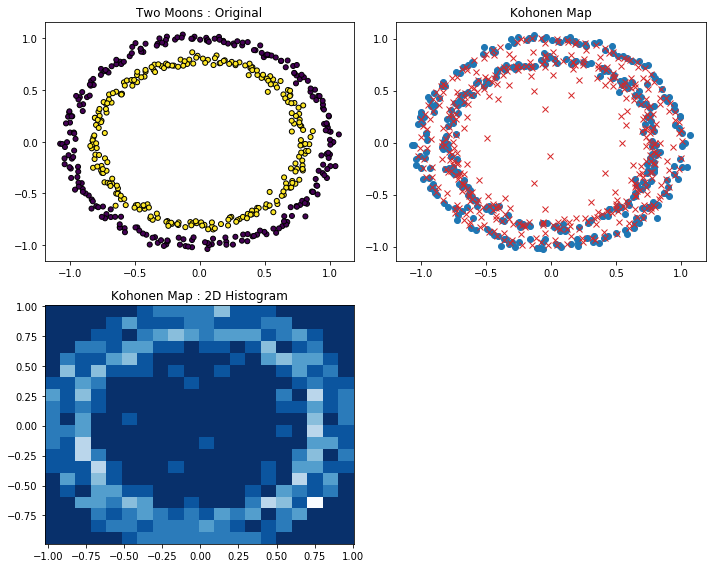

In [1996]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Two Moons : Original")
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hist2d(W[:, 0], W[:, 1], bins=20, cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

In [1997]:
X, y = make_blobs(500, n_features=2, centers=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

som = SOM(units=20, lr=1e-1, radius=10)
som.train(X_train, epochs=100)
W = som.W.flatten().reshape(-1, 2)

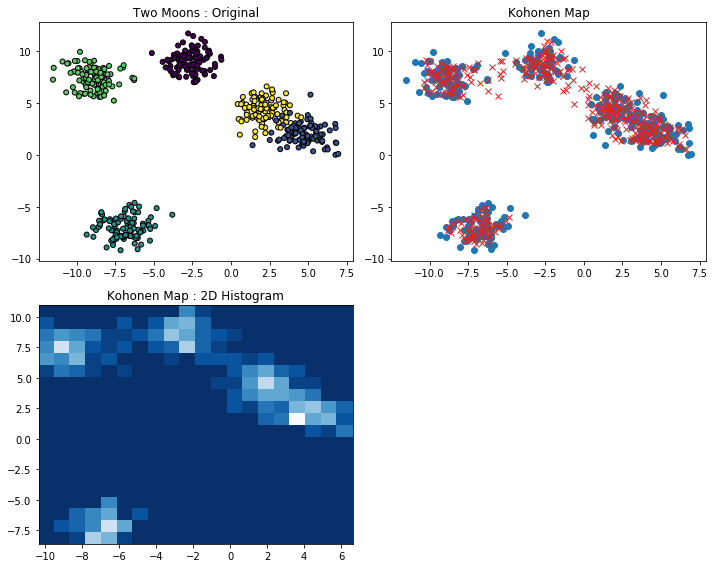

In [1998]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Two Moons : Original")
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hist2d(W[:, 0], W[:, 1], bins=20, cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

## Self-organizing map on MNIST

Using an Autoencoder on MNIST to retrive the latent variables... and then applying SOM.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=32, shuffle=True, num_workers=2)
testloader  = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=True, num_workers=2)

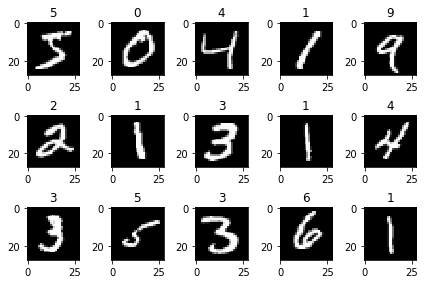

In [2007]:
for i in range(15):
    img, title = mnist_trainset.data[i], mnist_trainset.targets[i]
    plt.subplot(3, 5, i + 1)
    plt.title(title.item())
    plt.imshow(img.numpy(), cmap="gray")
plt.tight_layout()
plt.show()

#### Autoencoder

Taken from : [Building Autoencoder in Pytorch](https://medium.com/@vaibhaw.vipul/building-autoencoder-in-pytorch-34052d1d280c)

In [2055]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        
        self.decoder = nn.Sequential(             
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )
    
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [2056]:
num_epochs = 2

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

for epoch in range(num_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # ===================forward=====================
        outputs = model(inputs.to(device))
        loss = criterion(outputs.to(device), inputs.to(device))
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss))

epoch [1/2], loss:0.0333
epoch [2/2], loss:0.0294


In [2059]:
outputs = None
labels = []
for i, data in enumerate(testloader, 0):
    inputs, lbs = data
    outputs = model.encoder(inputs.to(device))
    labels.append(lbs)
    break
pic = to_img(outputs[0].cpu().data)

RuntimeError: shape '[8, 1, 28, 28]' is invalid for input of size 32